In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [7]:
region, rat = "FOF", "T036"

("FOF", "T036")

In [8]:
sessions = filter(x->occursin(rat,x), readdir(path))

12-element Array{String,1}:
 "T036_154154.mat"
 "T036_154291.mat"
 "T036_154448.mat"
 "T036_154991.mat"
 "T036_155124.mat"
 "T036_155247.mat"
 "T036_155840.mat"
 "T036_157201.mat"
 "T036_157357.mat"
 "T036_157507.mat"
 "T036_168499.mat"
 "T036_168627.mat"

In [9]:
output = load.(joinpath.(path, sessions[end-2:end]), false, delay=0.05);

In [10]:
data = getindex.(output, 1);

In [11]:
θy = Sigmoid(10.,60.,0.3,1.)

Sigmoid{Float64}
  a: Float64 10.0
  b: Float64 60.0
  c: Float64 0.3
  d: Float64 1.0


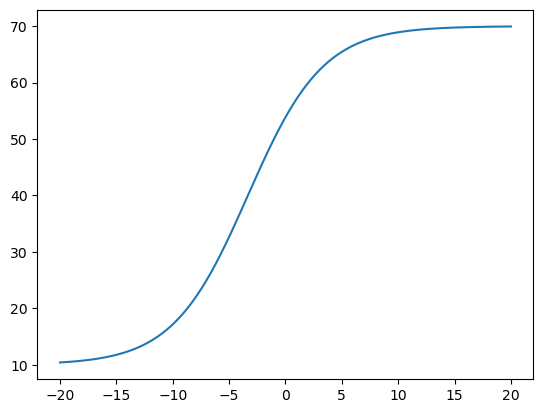

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd2d6d3e4e0>

In [12]:
using PyPlot
plot(collect(-20.:0.1:20.), θy.(collect(-20.:0.1:20.), 0.))

In [ ]:
f, ncells, ntrials, nparams = "Softplus", map(x-> x[1].ncells, data), length.(data), 3

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 40., λ = -0.5, σ2_a = 50., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Softplus(10., rand([-1.,1.]),0.) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

In [13]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Sigmoid{Float64},1}}((3,))
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 4
  f: String "Sigmoid"


In [14]:
ntrials

3-element Array{Int64,1}:
 389
 339
 431

In [ ]:
f, ncells, ntrials, nparams = "Sigmoid", [2], [5_000], 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

In [ ]:
f, ncells, ntrials, nparams = "Sigmoid", [5,4,2], [300,400,500], 4

θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 20., λ = -0.5, σ2_a = 10., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Sigmoid(10., 60., 0.3*rand([-1,1]), rand([-1.,1.])) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

In [15]:
data, μ_rnt, μ_t = synthetic_data(θ_syn, ntrials; centered=true, pos_ramp=true);

In [16]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=2);

In [17]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [18]:
_, μ_c_λ = pulse_input_DDM.synthetic_λ(θ_syn, data; num_samples=100, nconds=2);

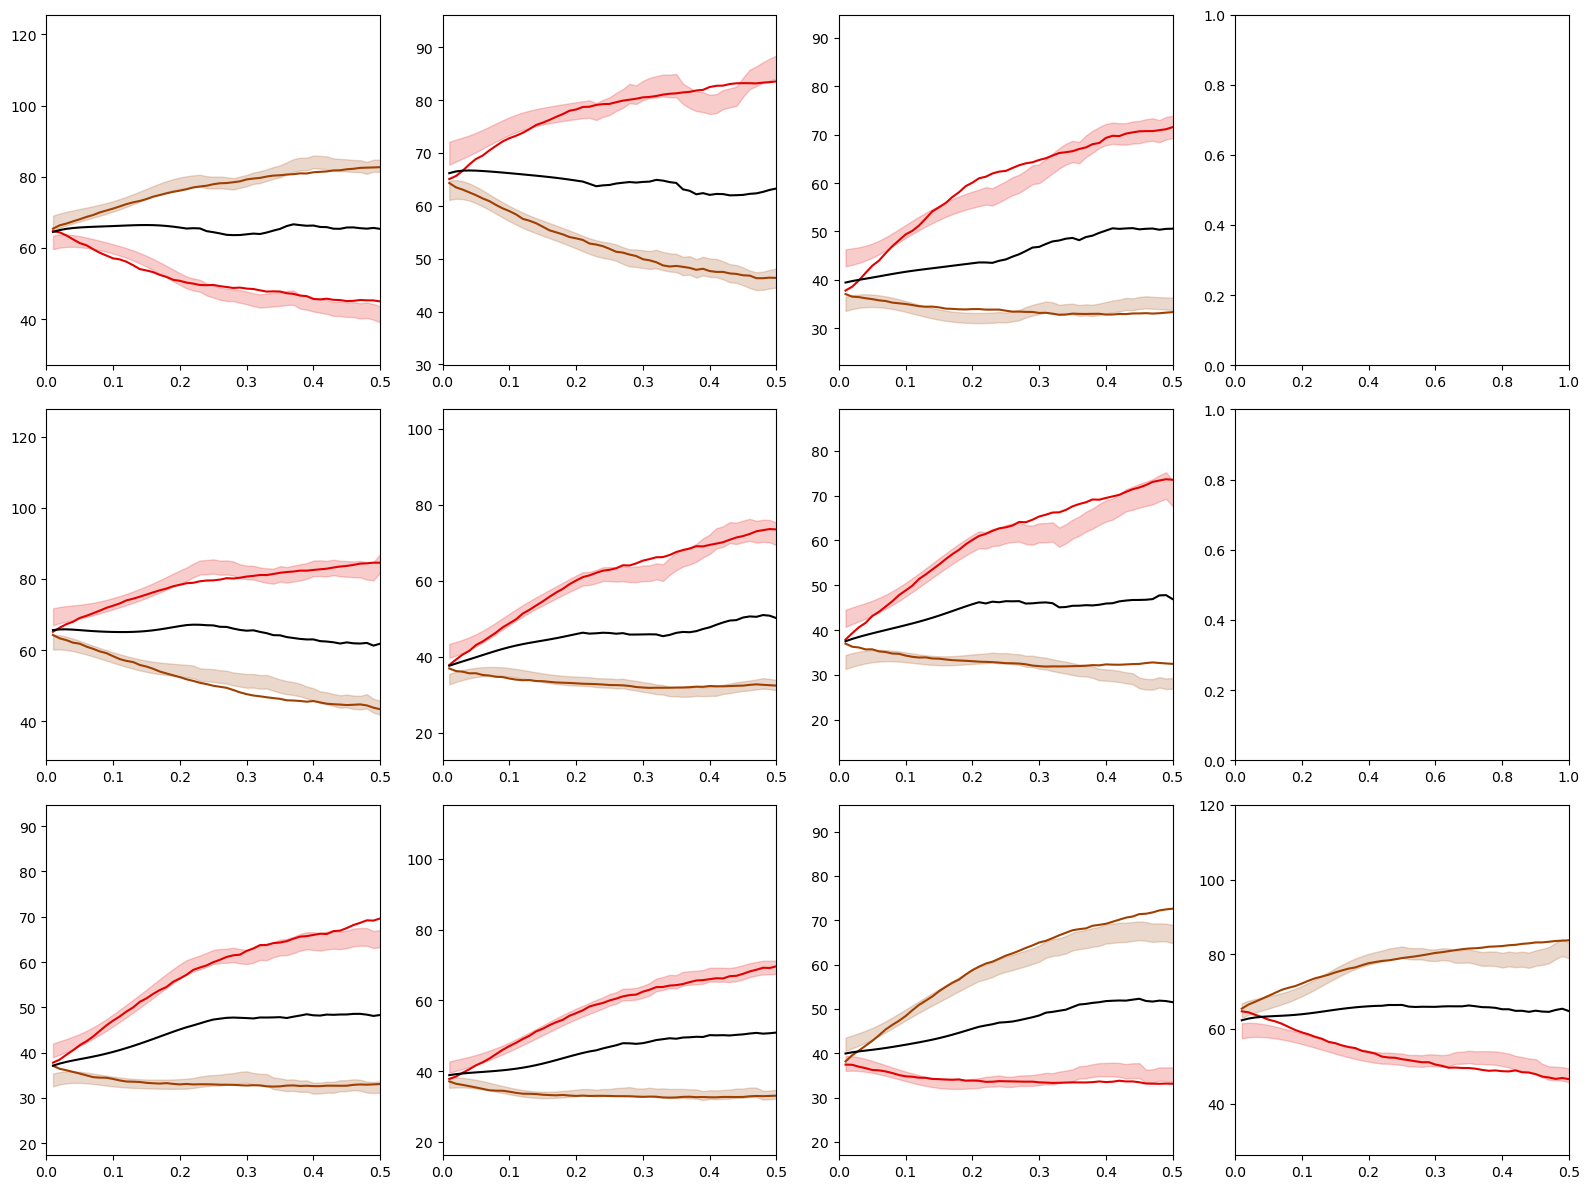

In [19]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [20]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [21]:
options = neuraloptions(ncells=ncells, 
    x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0),
    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f)

neuraloptions
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((47,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((47,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -100.0, 0.0, -10.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((47,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, 100.0, 100.0, 10.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((47,)) [0.1, 12.0, -2.0, 10.0, 0.1, 0.8, 0.008, 30.263157894736842, 61.21381404809005, 0.012630371732181468  …  -0.011860973782410422, 0.0, 30.139372822299652, 55.41887960488482, 0.011834524840368085, 0.0, 32.270168855534706, 56.443423377475, 0.011687641542365042, 0.0]


In [22]:
n = 53
loglikelihood(θ_syn, data, n)

-222210.92160483904

In [ ]:
model, = optimize(data, options, n)

Fminbox
-------
Initial mu = 0.192251

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.192251

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.376226e+05     6.145012e+03
 * time: 5.316734313964844e-5
     1     2.374649e+05     6.174454e+03
 * time: 6.599049091339111
     2     2.309125e+05     1.310965e+04
 * time: 13.204267024993896
     3     2.297015e+05     4.932573e+02
 * time: 19.774200201034546
     4     2.295054e+05     5.041031e+02
 * time: 26.557537078857422
     5     2.290833e+05     4.331851e+02
 * time: 33.51613712310791
     6     2.290787e+05     4.328248e+02
 * time: 40.344725131988525
     7     2.288475e+05     4.589643e+02
 * time: 46.94635319709778
     8     2.287505e+05     5.249684e+02
 * time: 53.37067198753357
     9     2.282462e+05     5.559190e+02
 * time: 59.78886318206787
    10     2.280150e+05     5.651910e+02
 * time: 66.1460690498352
    11     2.270996e+05     1.558296e

   118     2.221879e+05     6.491377e+02
 * time: 1004.8306519985199
   119     2.221771e+05     1.811509e+02
 * time: 1014.3121039867401
   120     2.221496e+05     3.387364e+02
 * time: 1023.8571491241455
   121     2.221432e+05     4.915092e+02
 * time: 1033.44047498703
   122     2.221339e+05     2.429216e+03
 * time: 1039.8187501430511
   123     2.221329e+05     2.300384e+03
 * time: 1049.2818520069122
   124     2.221262e+05     2.270790e+03
 * time: 1058.912854194641
   125     2.221211e+05     7.552030e+02
 * time: 1068.6120030879974
   126     2.221184e+05     4.613071e+02
 * time: 1078.468080997467
   127     2.221148e+05     5.689180e+02
 * time: 1084.992789030075
   128     2.221143e+05     7.204521e+01
 * time: 1091.3964910507202
   129     2.221137e+05     3.198682e+02
 * time: 1097.9711771011353
   130     2.221120e+05     3.543559e+02
 * time: 1104.5139591693878
   131     2.221117e+05     9.679226e+01
 * time: 1110.96568608284
   132     2.221113e+05     7.711667e+01


optimization complete. converged: true 



In [ ]:
hcat(collect(pulse_input_DDM.flatten(model.θ)), collect(pulse_input_DDM.flatten(θ_syn)))

In [46]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=2);

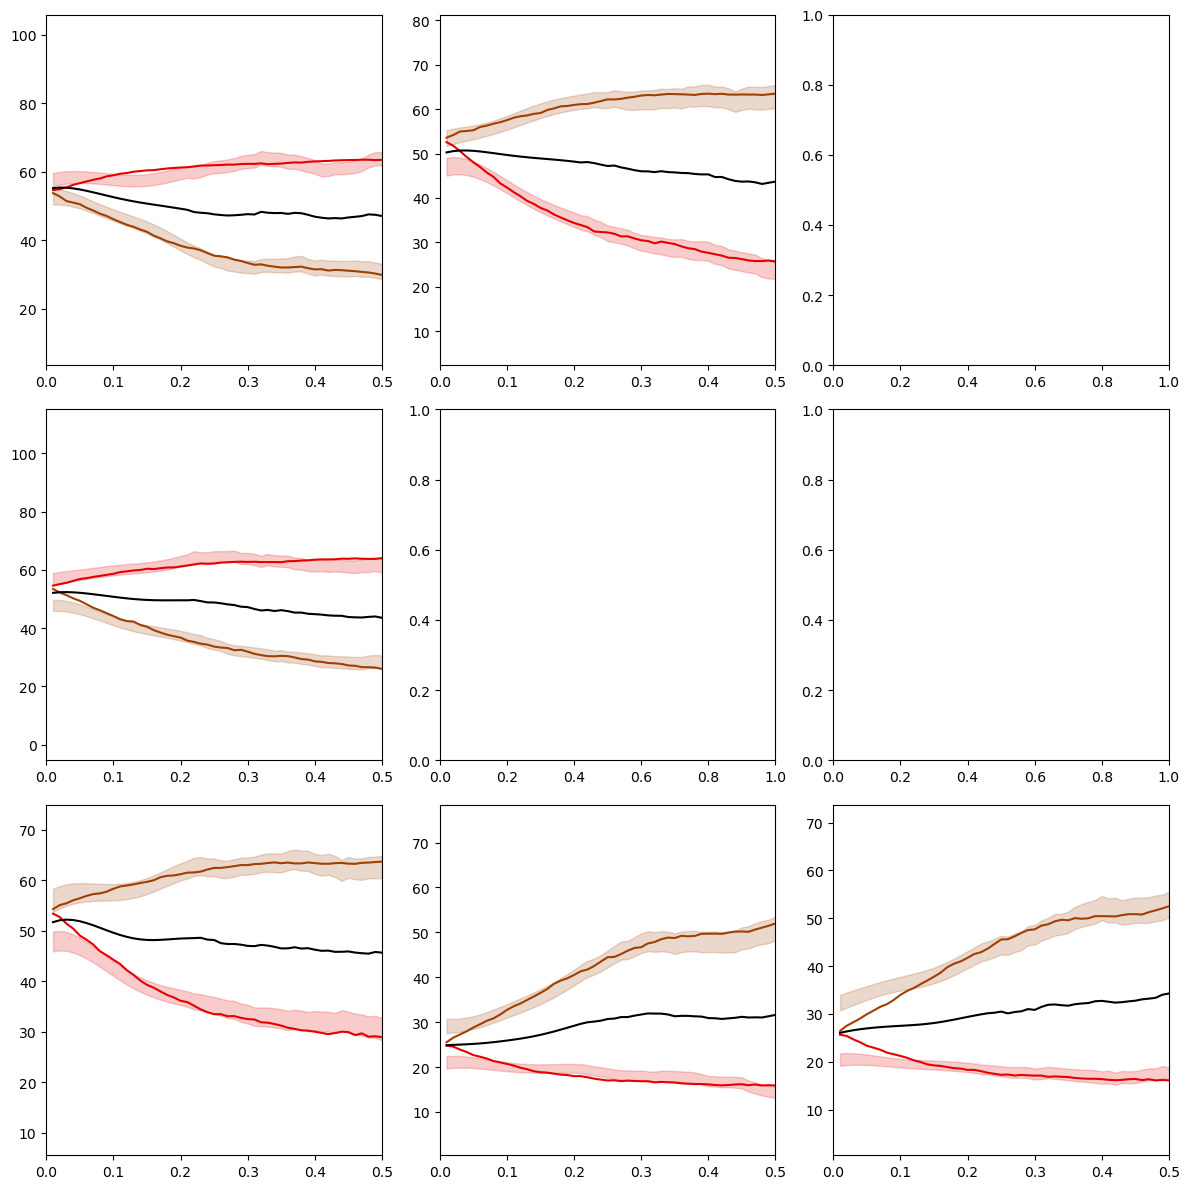

In [47]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [48]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

In [49]:
CI

31-element Array{Float64,1}:
  2.7712442927206933  
  3.6913908876206274  
  0.4217821744552872  
 28.25925344877081    
  0.6496236267283738  
  0.2088557793335898  
  0.014202252790161593
  3.508698208523339   
  5.149389075585247   
  0.097202462549553   
  0.36171731526555917 
  3.3338055195732452  
  5.8359284719441735  
  ⋮                   
  4.2523038515444735  
  6.203489577557629   
  0.08557408734550453 
  0.30659089849476656 
  2.325260970272566   
 18.611049602059246   
  0.07061935969810022 
  0.26044025198395665 
  1.9876333934436463  
 12.522503908035256   
  0.06632803930290973 
  0.22680991503055695 

In [50]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI, collect(pulse_input_DDM.flatten(θ_syn)), collect(pulse_input_DDM.flatten(model.θ)) + CI)

31×3 Array{Float64,2}:
 -2.22048      0.5    3.32201  
 10.7091      40.0   18.0919   
 -0.977114    -0.5   -0.13355  
 11.2432      50.0   67.7617   
 -0.195035     0.1    1.10421  
  0.460124     0.6    0.877835 
  0.00427288   0.02   0.0326774
  7.28554     10.0   14.3029   
 51.2451      60.0   61.5439   
 -0.423275    -0.3   -0.22887  
  0.942977     1.0    1.66641  
  8.30226     10.0   14.9699   
 53.7647      60.0   65.4366   
  ⋮                            
  4.96254     10.0   13.4671   
 53.1553      60.0   65.5623   
  0.205983     0.3    0.377131 
  0.822938     1.0    1.43612  
  6.46834     10.0   11.1189   
 52.368       60.0   89.5901   
  0.136607     0.3    0.277846 
 -1.51112     -1.0   -0.990242 
  6.86834     10.0   10.8436   
 54.5527      60.0   79.5977   
  0.155096     0.3    0.287752 
 -1.33791     -1.0   -0.884291 

In [52]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI .< 
    collect(pulse_input_DDM.flatten(θ_syn)) .< 
    collect(pulse_input_DDM.flatten(model.θ)) + CI)

31×1 BitArray{2}:
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 0
 1